In [1]:
# This cell only for package version control
import sys
import qiskit
import numpy
import matplotlib
print('python    :', sys.version)
print('qiskit    :',qiskit.__version__, qiskit.__qiskit_version__)
print('numpy     :',numpy.__version__)
print('matplotlib:',matplotlib.__version__)

python    : 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
qiskit    : 0.17.1 {'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}
numpy     : 1.20.2
matplotlib: 3.3.4


# Introduction

The quantum Fourier transform and quantum phase estimation provide the foundation for many quantum algorithms, including the quantum matrix inversion, which is extensively used in quantum machine learning. It is therefore worthwhile developing a good understanding of these building blocks before moving on to more complex algorithms.

We must emphasize that starting with this notebook, the algorithms presented are coherent quantum protocols. By that, we mean that the input and output of an algorithm is a quantum state that we do not have classical information about. The protocol itself might use measurements: in this sense, they are not fully coherent, since we gain some, but incomplete classical information about the quantum system. We might also perform post-selection, which means that a gate is controlled by the classical output of a measurement. In some cases, we entirely discard a calculation based on a measurement output.

Why does it matter that we begin and end up with quantum states? Can't we just use state preparation starting from classical data and then perform tomography on the final state? We could do that, but state preparation and tomography are resource-intensive, and they are likely to destroy any quantum advantage. Exponential speedup can only happen if the input state is already encoded in a quantum state, or can be easily coded. This is not trivial, as in Quantum Computing there are currently no efficient ways of reading a file with input, or any efficient RAM system design. Besides, if we do a measure, we obtain only states with certain probability.

An additional problem is that the quantum Fourier transformation and other quantum algorithms similar in complexity require a very large number of gates on a large number of high-quality qubits. This is why the practical relevance of these algorithms is not immediate, but since they are the core of many quantum machine learning protocols, it is essential that we take a look at them.

In [2]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer as Aer
import numpy.fft as fft
π = np.pi

# Quantum Fourier Transform

The Fourier Transform is an operation which transforms a function into a sum of complex exponentials. It is a very powerful tool in many algorithms and has widespread use.  For instance, it could be used to transform the air pressure variations of a musical symphony into a description using pure (sinusoidal)  musical notes. The transform in general is reversible, and its discrete version is a unitary matrix as we will see. This already suggests that we can turn the Fourier transform into a quantum algorithm. 

The Quantum Fourier Transform (QFT) algorithm changes the state of the input qubits so that the coefficient of the output state are the Fourier transform of the input coefficients. The problem we signaled above is that, being the output a quantum state, there is no way of accessing these values directly. Rather, only one of the possible output states is observed, with a probability equal to the square of the absolute value of its coefficient. 

QFT algorithm is used as part of some other algorithms, including factoring (Shor's algorithm), finding patterns, and Quantum Phase Estimation, which is the main topic in this lecture.


The quantum Fourier transform is a quantum algorithm for the discrete Fourier transform over the amplitudes of a wavefunction. The exposition here follows the introduction in [[1](#1)]. 

The classical discrete Fourier transform acts on a vector $\vec{x}=\begin{bmatrix}x_0\\ \vdots\\ x_{N-1}\end{bmatrix}$ and maps it to the vector $\vec{y}=\begin{bmatrix}y_0\\ \vdots\\ y_{N-1}\end{bmatrix}$, where $y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{ \boldsymbol{2\pi i} \frac{jk}{N}}$.

The quantum Fourier transform acts on an amplitude-encoded variant of this vector, the quantum state $|x\rangle=\sum_{i=0}^{N-1} x_i |i \rangle$ and maps it to the quantum state $|y\rangle=\sum_{k=0}^{N-1} y_k |k \rangle$, where
$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{\boldsymbol{2\pi i} \frac{jk}{N}}$. Since the transformed state is also in the superposition of the computational basis, in essence, only the amplitudes are transformed.

To derive a circuit for a power of two $N=2^n$, consider the transform acts on the state $| x \rangle = | x_1...x_n \rangle$ where $x_1$ is the most significant bit, unlike the usual convention followed in the course. We will rewrite a number $y$ in the fractional binary notation  as $j = 0.j_1...j_n = \sum_{k=1}^n j_k/2^k$. For example $0.8125_d = 0.1101_b = \sum_{k=1}^4 j_k/2^k = 1/2 + 1/4 + 0/8 + 1/16$, where the subscripts $d$ stands for decimal and $b$ for binary. The action of the unitary $U$ describing the transform can be expanded as:


\begin{align}
U |j \rangle = U |j_1 j_2 \cdots j_n \rangle& = \frac{1}{\sqrt{N}} \sum_{k=0}^{2^n-1} e^{2\pi i jk / 2^n} |k \rangle \tag 1 \\
&
\\
\end{align}
if we notice that
\begin{align}
\\ 
k/2^n = \frac{1}{2^{n}}\left(\sum_{l=1}^{n}k_12^n + k_22^{n-1}+\ldots+k_n2^0\right)= \sum_l^nk_l2^{-l}
\\
\end{align}
expression (1) becomes:
\begin{align}
\\
 U |j \rangle &= \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} e^{2\pi i j\left(\sum_{l=1}^n k_l2^{-l}\right) } \vert k_1 ... k_n \rangle \\
&= \frac{1}{\sqrt{N}} \sum_{k_1=0}^{1}\ldots\sum_{k_n=0}^{1} \bigotimes_{l=1}^n e^{2\pi i j k_l2^{-l}} | k_1 ... k_n \rangle \\
&= \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n \sum_{k_l=0}^{1}  e^{2\pi i j k_l2^{-l}} | k_1 ... k_n \rangle \\
&= \frac{1}{\sqrt{N}} \bigotimes_{l=1}^n  \left(|0\rangle + e^{2\pi i j 2^{-l} } |1\rangle \right)\tag 2 \\
\end{align}
now, using the equality 
\begin{align}
\\ e^{2\pi i \left(j_1j_2.j_3j_4j_{n-1}j_n\right)} = e^{2\pi i \left(j_1j_2\right)}e^{2\pi i \left(0.j_3j_4...j_{n-1}j_n\right)} = 1.e^{2\pi i \left(0.j_3j_4...j_{n-1}j_n\right)}
\\
\end{align}
we have finally
\begin{align}
& U |j \rangle = \frac{1}{\sqrt{N}} \left(|0\rangle + e^{2\pi i 0.j_n} |1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{2\pi i 0.j_1.j_2...j_{n-1}.j_n} |1\rangle\right) \tag 3
\end{align}


This form of the QFT is useful for deriving a circuit, since only the last qubit depends on the the
values of all the other input qubits. The remaining qubits depend less and less on the input qubits. 

The simple structure of eqn.(3) also allows to decompose the unitary as a combination of Hadamard gates and simple rotations.

The first operation is a Hadamard as:

$$\begin{align}
H|j_1\rangle |j_2j_3...j_n\rangle &=\frac{1}{\sqrt2}\left(|0\rangle+|1\rangle\right)|j_2j_3...j_n\rangle,\text{when }j_1 \text{equals 0, and} \\
&=\frac{1}{\sqrt2}\left(|0\rangle-|1\rangle\right)|j_2j_3...j_n\rangle, \text{when }j_1\text{ equals 1}
\\
&= \frac{1}{\sqrt2}\left(|0\rangle+e^{\pi ij_1}|1\rangle\right)|j_2j_3...j_n\rangle, \text{when }j_1\in\{0,1\}\\
\end{align} $$
<br>

Using binary fractions: $e^{2\pi i \left(j_1/2\right)} = e^{2\pi i 0.j_1} $ we can write:

$$ H|j_1\rangle|j_2j_3...j_n\rangle = \frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1}|1\rangle\right)|j_2j_3...j_n\rangle$$

which concludes the first step.


To handle the further steps in the transformation, we first define the (discrete phase) rotation as: 


$$R_k =\begin{pmatrix} 
1 & 0\\
0 & e^{2\pi i/2^k} \\
\end{pmatrix}$$

It is easy to see that 


\begin{aligned}
R_k|0\rangle = |0\rangle, R_k|1\rangle = e^{\frac{2\pi i}{2^{k}}}|1\rangle
\end{aligned}

We'll use controlled gates to apply the above rotation if the control qbit is $|1\rangle$ and do nothing if it is $|0\rangle$.

If we apply $cR_2$, the rotation conditional of $j_2$ to $|j_1\rangle$ we get

$$
\begin{aligned}
cR_2\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1}|1\rangle\right)|j_2j_3...j_n\rangle =&
\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_10}|1\rangle\right)|j_2j_3...j_n\rangle, \; \text{if} j_2 = 0, \\
=&\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_11}|1\rangle\right)|j_2j_3...j_n\rangle, \; \text{if} j_2 = 1, \\
=&\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1j_2}|1\rangle\right)|j_2j_3...j_n\rangle,\; j_2 \in\left\{0,1\right\}\\
\end{aligned}
$$

Successive application of the conditional rotations $cR_3$,$cR_4$.......$cR_n$ yields,

$$cR_n cR_{n-1}\dots cR_3cR_2\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1}|1\rangle\right)|j_2j_3...j_n\rangle =
\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1j_2 \dots j_{n-1}j_n}|1\rangle\right)|j_2j_3...j_n\rangle,$$

And for the 2nd qubit in the j-register
<br>

$\frac{1}{\sqrt2}\left(|0\rangle + e^{2\pi i 0.j_1}|1\rangle\right)cR_n cR_{n-1}\dots cR_4cR_3H|j_2\rangle|j_3...j_n\rangle =
\frac{1}{\sqrt{2^2}}\left(|0\rangle + e^{2\pi i 0.j_1j_2 \dots j_{n-1}j_n}|1\rangle\right)\left(|0\rangle + e^{2\pi i 0.j_2 \dots j_{n-1}j_n}|1\rangle\right)|j_3...j_n\rangle,$$

Successive application to all qubits in the j-register yields:

$
|j_1j_2 \dots j_{n-1}j_n\rangle \xrightarrow{QFT} \frac{1}{\sqrt{N}} \left(|0\rangle + e^{2\pi i 0.j_1j_2 \dots j_{n-1}j_n}|1\rangle\right).\left(|0\rangle + e^{2\pi i 0.j_2 \dots j_{n-1}j_n}|1\rangle\right)\dots \left(|0\rangle + e^{2\pi i 0.j_{n-1}j_n}|1\rangle\right)\left(|0\rangle + e^{2\pi i 0.j_n}|1\rangle\right) \tag 4 \\
$

Which, except for a reversal of the output bits, is equal to eqn(3), showing that we can build the required transform with just H and simple rotation gates.



<img src="../figures/QFT.jpg" style="width:900px;height:500px"/>

 For a three qubit QFT, the circuit is defined as:

In [3]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')
qft = QuantumCircuit(q, c)
#act on the first qubit
qft.h(q[0])
#R2
qft.cp(π/2, q[1], q[0])
#R3
qft.cp(π/4, q[2], q[0])
#then on the second qubit
#R2
qft.h(q[1])
qft.cp(π/2, q[2], q[1])
#and the 3rd qubit only requires a Hadamard
qft.h(q[2])

We can plot it to make the qubit dependencies more apparent:

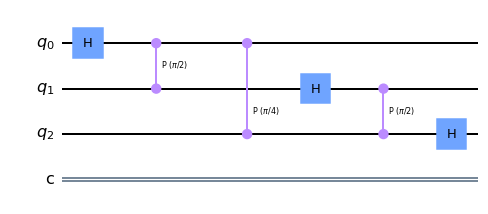

In [4]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qft, output = 'mpl')

The conditional rotations dominate the complexity, which scales as $O(N^2)$.

To see if this works properly, we make a comparison with the standard FFT routine in numpy. We use a simple 4 sample sequence that could be e.g. a time series measurement: [ 1, -1, -1, 1], and use only 2 qubits to do so. This is also allows us to design the inverse transform that we will need for the next chapter; 'Quantum Phase Estimation'.<br>
Note that the preparation of the input data, even for this very simple case, already requires quite some work

 input vector   [ 0.5 -0.5 -0.5  0.5]


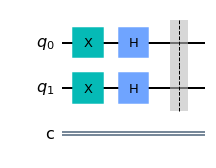

In [5]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(1, 'c')
qft = QuantumCircuit(q, c)

#prepare the input state [1, -1, -1, 1]
qft.x(q[0])
qft.h(q[0])
qft.x(q[1])
qft.h(q[1])
qft.barrier()

res = execute(qft, Aer.get_backend('statevector_simulator')).result()
inp = np.array(np.real(res.get_statevector(qft)))
print(' input vector  ',inp)
circuit_drawer(qft, output='mpl')

Let's compare the QFT with a numpy FFT. NB as numpy uses a different sign convention in the forward FFT, we  used the inverse numpy FFT to get the same sign convention as for our QFT

In [6]:
#forward QFT
qft.h(q[0])
qft.cp(π/2, q[1], q[0])
qft.h(q[1])

res = execute(qft, Aer.get_backend('statevector_simulator')).result()
qft_outp = np.array(res.get_statevector(qft))
print('       QFT     ',qft_outp)


#compute the numpy IFT
x = np.array([1., -1., -1., 1.])
y = fft.ifft(x)
print(' numpy FFT     ',y)

       QFT      [0. +0.j  0.5-0.5j 0. +0.j  0.5+0.5j]
 numpy FFT      [0. +0.j  0.5-0.5j 0. +0.j  0.5+0.5j]


We now create the inverse QFT for 2 qubits, as we will use this in the chapter on Quantum Phase Estimation. For this purpose we note that since $F^{-1}F = I$ we just have to run the circuit from right to left, and reverse the angles.

In [7]:
qft.barrier()
qft.h(q[1])
qft.cp(-π/2, q[1], q[0])
qft.h(q[0])

res = execute(qft, Aer.get_backend('statevector_simulator')).result()
iqft_outp = np.array(res.get_statevector(qft))
print(' QFT-IQFT       ',iqft_outp)
print(' original input ',inp)

 QFT-IQFT        [ 0.5-2.99590143e-16j -0.5+4.22054823e-16j -0.5+2.16323416e-16j
  0.5-3.38788096e-16j]
 original input  [ 0.5 -0.5 -0.5  0.5]


# Quantum phase estimation

The goal of a quantum phase estimation algorithm is, given a unitary operator $U$ and an eigenvector $|u\rangle$ of $U$, to estimate $\theta$ in  $U|u\rangle =e^{2 i \pi \theta}|u\rangle$. Since $U$ is unitary, all of its eigenvalues have an absolute value of 1. By convention, $\theta$ is taken to be in $[0,1]$ and is called the *phase* of $U$ associated to $|u\rangle$.

The eigenvector $|u\rangle$ is encoded in one set of quantum registers. An additional set of $n$ qubits forms an ancilla register. At the end of the procedure, this ancilla register should contain an approximation of the [binary fraction](https://www.electronics-tutorials.ws/binary/binary-fractions.html) associated to $\theta$, with n-bits precision. 

A critical element is the ability to perform the controlled unitary $\text{cU}^{2^k}$ -- it is usually assumed to be provided to the phase estimation protocol.

We will use some of the techniques employed in the derivation of the QFT to calculate the eigenvalues up to a desired accuracy of $\theta$. First, the uniform superposition is prepared in the ancilla register via the application of Hadamard gates $H$. These qubits will act as controls for subsequent application of the unitary operators $\text{cU},\text{cU},^2\dots, \text{cU}^{2^{n-2}},\text{cU}^{2^{n-1}}$ on $|u\rangle$. 



<img src="../figures/QPE.jpg" style="width:1200px;height:450px"/>







So, we have a register which is initially prepared in a eigenstate $|u\rangle$ of $U$ and remains in this same state after the computation, whereas the ancilla evolves into a new state. 
Why does the ancilla-register change? After all, it just contains control qubits. To better understand this, lets look at the control qubit $|x_j\rangle$ and the effect on the entire system of the application over 
it of the controlled rotation (for brevity we leave out the other qubits in the x-register as they are not affected):

\begin{align}
|0\rangle_j|u\rangle \overset{U^{2^{j}}}\rightarrow|0\rangle_j|u\rangle,\quad 
|1\rangle|u\rangle \overset{U^{2^{j}}}\rightarrow|1\rangle_j U^{2^{j}}|u\rangle = e^{2^{j}i\theta }|1\rangle_j|u\rangle
\end{align}



as $e^{i\theta }$ is an eigenvalue of $U$, and essentially just a number, we can associate it with either the x- or the u-register. Hence:

\begin{align}
U^{2^j}\left(|0\rangle_j + |1\rangle_j\right)|u\rangle = \left(|0\rangle_j +e^{2^{j}i\theta } |1\rangle_j\right)|u\rangle
\end{align}

Because we use a superposition in the control bit, what would otherwise be a global phase as result of transformations, is now captured in the control bit state. The phenomenon is also known as the 'phase kickback'.


After applying all controlled rotations we have ended up with a superposition of n-bits in the binary expansion of  $\theta$ in the ancilla register. We can leave $|u\rangle$ out of the expression as it is unchanged and not entangled with the x-register:



\begin{align}
& \frac {1}{{\sqrt2}^n} (|0\rangle+{e^{2 i \pi \theta \cdot 2^{n-1}}}|1\rangle ) (|0\rangle+{e^{2 i \pi \theta \cdot 2^{n-2}}}|1\rangle ) \cdots (|0\rangle+{e^{2 i \pi \theta \cdot 2^{1}}}|1\rangle )  (|0\rangle+{e^{2i \pi \theta \cdot 2^{0}}}|1\rangle ) = \tag 5 \\
&\frac {1}{\sqrt2^n}\sum _{k=0}^{2^{n}-1}e^{2 i \pi \theta k}|x_k\rangle
\end{align}


As a final step, we apply an inverse Fourier transform on the ancilla. But comparing eqn(4) with eqn (5) shows that the order of the qubits appear reversed, hence before we proceed with the IQFT we need to reverse the order of the qbits. Then, after applying the IQFT, we measure out in the computational basis and get the phase in the ancilla register:

\begin{align}
\frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{2i \pi \theta k}|k\rangle \otimes | u \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} | \tilde{\theta} \rangle \otimes | u \rangle
\end{align}



where $\tilde{\theta}$ is the n-bits approximation of the binary fraction representing $\theta$.


As a toy example, let's take the $2\times 2$ unitary matrix $\begin{bmatrix}e^{0} & 0 \\0 & e^{i \pi}\end{bmatrix}=\begin{bmatrix}1 & 0 \\0 & -1\end{bmatrix}$, which has the eigenvectors $|0\rangle$ and $|1\rangle$, and phases $\theta_0=0$ and $\theta_1=\frac{1}{2}$. This is a convenience choice as it allows us to represent the eigenvalues with only two bits, without any approximation.


Therefore, the $cU^{2^k}$ gate is a controlled-$Z$ gate for $k=0$ and the identity for $k\geq 1$.

Starting with $|u\rangle=|0\rangle$ in the main register, we prepare the superposition in the ancilla:

In [8]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.h(q[0])  # ancilla qubit |x0>
qpe.h(q[1])  # ancilla qubit |x1>
qpe.i(q[2]) # |u>

Next we perform the controlled unitary operations:

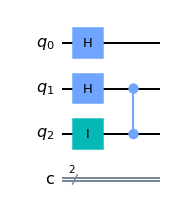

In [9]:
# Controlled-U0
qpe.cz(q[1], q[2])
# Controlled-U1
# in this case nothing: identity as cZ.cZ = Identity

circuit_drawer(qpe, output='mpl')

Before we can apply the quantum inverse Fourier transformation to write the phase to the ancilla register we need to first swap the registers around:

In [10]:
qpe.swap(q[0], q[1])
qpe.barrier()


Now apply the 2-qubit QIFT as above

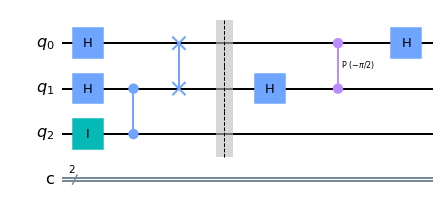

In [11]:
qpe.h(q[1])
qpe.cp(-π / 2, q[1], q[0])  
qpe.h(q[0])
circuit_drawer(qpe, output='mpl')

We will get the result from the two first registers

In [12]:
qpe.barrier()
qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

We can plot the circuit:

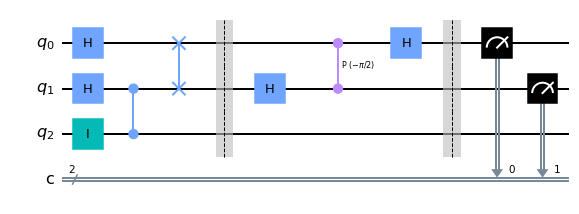

In [13]:
circuit_drawer(qpe, output = 'mpl')

Let's now test our circuit:

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
result.get_counts(qpe)

{'00': 1000}

The result should be $\theta = 0.q_0q_1$, hence $\theta = q_0\cdot 2^{-1} +q_1\cdot 2^{-2} = 0\cdot2^{-1} +0\cdot2^{-2} = 0$

Let's now run the circuit for the eigenvector $|1\rangle$:

In [15]:
qpe = QuantumCircuit(q, c)
qpe.h(q[0])
qpe.h(q[1])
qpe.x(q[2]) # create |1> in the main register
# Controlled-U0
qpe.cz(q[1], q[2])
# Controlled-U1

qpe.swap(q[0], q[1])
qpe.h(q[1])
qpe.cp(-π / 2, q[1], q[0])
qpe.h(q[0])
#qpe.swap(q[0], q[1])

qpe.measure(q[0], c[0])
qpe.measure(q[1], c[1])

In [16]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qpe, backend, shots=1000)
result = job.result()
print( '{q1, q0}',result.get_counts(qpe))

{q1, q0} {'01': 1000}


The result should be $\theta = 0.q_0q_1$, hence $\theta = q_0\cdot 2^{-1} +q_1\cdot 2^{-2} = 1\cdot2^{-1} +0\cdot2^{-2} = 0.5$


# References
[1] M. Nielsen, I. Chuang. (2000). *Quantum Computation and Quantum Information*. Cambridge University Press. <a id='1'></a>

[2] B. Schölkopf, Alexander J. Smola. (2000). *Learning with Kernels*. MIT Press. <a id='1'></a>

[3] M. Schuld (2019). *Quantum Enhanced Kernel Methods 1*. https://www.youtube.com/watch?v=uDAAi5aQbMU <a id='1'></a>